In [5]:
import numpy as np
import commpy as cp
import scipy.signal as sig
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
from multiprocessing import Pool


%matplotlib inline
DEFAULT_SEED = 100
np.random.seed(DEFAULT_SEED)#set the random generator seed to default


def modulate(data, mod_scheme='BPSK', demod=False):
    """  1. Modulates (or demodulates) data according to the modulation scheme """
    mod_schemes = ['BPSK', 'QPSK']
    data = data.flatten()
    if mod_scheme not in mod_schemes:
        raise ValueError('Unknown modulation scheme, please choose from: '+ ' '.join(mod_schemes))
    elif mod_scheme == 'QPSK':
        modulator = cp.modulation.QAMModem(4)
        if demod:
            return modulator.demodulate(data, "hard")
        return modulator.modulate(data)
    elif mod_scheme == 'BPSK':
        def bpsk_one(x):
            if demod:
                return 0 if x < 0 else 1
            return -1 if x==0 else 1
        bpsk = np.vectorize(bpsk_one)
        return bpsk(data)
     

def channel(input_data_constellations, channel_function):
    """  2. Convolves modulated data with a randomly generated channel fcn of t taps  """
    channel_output = sig.convolve(input_data_constellations, channel_function, mode='full') # convolve input complex data with the channel transfer function
    return channel_output

def add_awgn_noise(signal,SNR_dB):
    """  3. Adds AWGN noise vector to signal (flat array) to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    return y.flatten()

    
def LMS(signal, pre_channel_sig, L, mu=0.05):
    """  
    Returns the LMS equalizer w/ SGD trained equalizer taps (length = 2L+1).
    Replaces expected error squared in MMSE with instantaneous error squared.
    """    
    order = 2*L + 1
    datatype = np.complex_ if isinstance(signal, complex) else np.float32
    h = np.zeros(order, dtype=datatype)
    signal = np.pad(signal.flatten(), L, 'constant', constant_values=(0j))
    for i in range(len(pre_channel_sig)):
        r = np.flip(signal[i: i+order],0)
        y = pre_channel_sig[i]
        h = h + mu * (y - np.dot(r, h)) * r.conj()
    return h 

def LS(received_signal, sent_signal, L, mu=0.05, steps=10, ALG=1):
    equalizer_length = L*2+1
    
    A = gen_matrix(received_signal, len(sent_signal), L)
    b = sent_signal
    h = np.zeros(equalizer_length) # implement random starts
    # Use closed form least squares solution [sanity check]
    if ALG == 0:
        h,_,_,_ = np.linalg.lstsq(A, b,rcond=-1)
    # Using gradient descent [method 1]
    if ALG == 1:
        while steps > 0:
            grad_update = np.dot(A.T, np.dot(A, h) - b)
            h = h - (mu / len(b))*grad_update
            steps -= 1
    return h

def zfEqualize(channel_output, channel):
    # make sure have same fft length 
    # we get the correct number of terms as this is like a circular convolution so the last packet is garbage
    if(isinstance(channel_output[0], complex)):
        freq_domain = np.fft.fft(channel_output, len(channel_output))/np.fft.fft(channel, len(channel_output))
        return np.fft.ifft(freq_domain)[0:len(channel_output) - len(channel) + 1]
    else:
        freq_domain = np.fft.rfft(channel_output, len(channel_output))/np.fft.rfft(channel, len(channel_output))
        return np.fft.irfft(freq_domain)[0:len(channel_output) - len(channel) + 1]
        
    
def predict(signal, eq_fcn, L):
    """ 4. Equalize the test signal where the equalizer order = 2L+1"""
    return sig.convolve(signal.flatten(), eq_fcn , mode="full")[L:]
    
def num_bit_errs(in_bits, out_bits):
    total = 0
    for i in range(len(in_bits)):
        if in_bits[i] != out_bits[i]:
            total += 1
    return total

def test(params={'channel_length':3, 'equalizer_L':3, 'snr':1, 'preamble_length':100, 'test_length':int(1e3), 'mu':0.01}, runs=1, specific_channel=False):
    modulation_scheme = "BPSK"
    avg_baseline_error = 0.
    avg_LMS_error = 0.
    avg_LS_error = 0.
    avg_ZF_error = 0.
    for i in range(runs):
        if specific_channel:
            channel_function = specific_channel
        else:
            # generate normalized channel function of consecutive taps
            channel_function = np.random.randn(params['channel_length']) 
            channel_function = channel_function / np.linalg.norm(channel_function)
        # generate training data
        preamble_bits = np.random.randint(0,2, params['preamble_length']) 
        train_symbols = modulate(preamble_bits, modulation_scheme)
        train_signal = add_awgn_noise(channel(train_symbols, channel_function), params['snr'])
        # generate testing data
        test_bits = np.random.randint(0,2, params['test_length'])
        test_symbols = modulate(test_bits, modulation_scheme)
        test_signal = add_awgn_noise(channel(test_symbols, channel_function), params['snr'])
        # calculating baseline error (no training)
        baseline_bits = modulate(test_signal, modulation_scheme, True)
        avg_baseline_error += num_bit_errs(test_bits, baseline_bits)

        # training equalizer taps LMS
        h_LMS =  LMS(train_signal, train_symbols, params['equalizer_L'], params['mu'])
        # calculating LMS testing error
        test_LMS = predict(test_signal, h_LMS, params['equalizer_L'])
        test_LMS = modulate(test_LMS, modulation_scheme, True)
        avg_LMS_error += num_bit_errs(test_bits, test_LMS)
        
        # training equalizer taps LS
        h_LS =  LS(train_signal, train_symbols, params['equalizer_L'], params['mu'])
        # calculating LS testing error
        test_LS = predict(test_signal, h_LS, params['equalizer_L'])
        test_LS = modulate(test_LS, modulation_scheme, True)
        avg_LS_error += num_bit_errs(test_bits, test_LS)
        
        # calculating ZF testing error
        test_ZF = zfEqualize(test_signal.flatten(), channel_function)
        test_ZF = modulate(test_ZF, modulation_scheme, True)
        avg_ZF_error += num_bit_errs(test_bits, test_ZF)
    return [avg_baseline_error/ (params['test_length']*runs), 
            avg_LMS_error/ (params['test_length']*runs),
            avg_LS_error/ (params['test_length']*runs),
            avg_ZF_error / (params['test_length']*runs)
           ] 


def plot_metric(metric_name, metric_range, semi_log=False, runs=1000, specific_channel=False,
                base_params={'channel_length':2, 'equalizer_L':2, 'snr':0.8, 'preamble_length':100, 'test_length':int(1e3), 'mu':0.01}):
    np.random.seed(0)
    params = base_params.copy()    # copy to not overwrite default dictionary
    plot_baseline_errors = []
    plot_LMS_errors = []
    plot_LS_errors = []
    plot_ZF_errors = []
    for i in metric_range:
        params[metric_name] = i
        baseline_err, LMS_err, LS_err, ZF_err = test(params, runs=runs, specific_channel=specific_channel)
        plot_baseline_errors.append(baseline_err)
        plot_LMS_errors.append(LMS_err)
        plot_LS_errors.append(LS_err)
        plot_ZF_errors.append(ZF_err)
    if semi_log:
        plt.semilogy(metric_range, plot_baseline_errors, 'Baseline')
        plt.semilogy(metric_range, plot_LMS_errors, label='LMS')
        plt.semilogy(metric_range, plot_LS_errors, label='LS')
        plt.semilogy(metric_range, plot_ZF_errors, label='ZF')
    else:
        plt.plot(metric_range, plot_baseline_errors, label='Baseline')
        plt.plot(metric_range, plot_LMS_errors, label='LMS')
        plt.plot(metric_range, plot_LS_errors, label='LS')
        plt.plot(metric_range, plot_ZF_errors, label='ZF')
    plt.title(metric_name.upper()+" vs Avg. bit errors over "+str(runs)+" runs")
    plt.xlabel(metric_name.upper())
    plt.ylabel("Avg. # bit errors")
    plt.legend()
    plt.show()
    for key in base_params:
        if not key == metric_name:
            print key + " = "+ str(base_params[key])

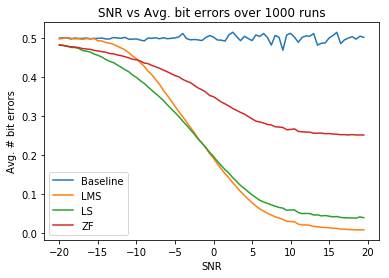

mu = 0.01
equalizer_L = 2
preamble_length = 100
algo = <function LMS at 0x108090a28>
test_length = 1000
channel_length = 2


In [6]:
# plot metric: snr
np.logspace(-100, 100, 20)
SNRs = np.arange(-100, 20, 1)
plot_metric("snr", SNRs, runs=1000)

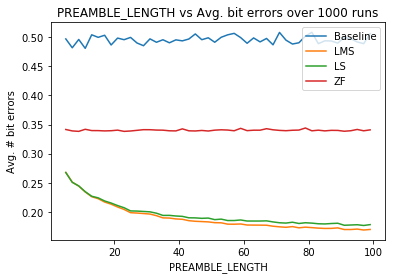

mu = 0.01
equalizer_L = 2
algo = <function LMS at 0x108090a28>
test_length = 1000
snr = 0.8
channel_length = 2


In [7]:
# plot metric: preamble length
preambles = np.arange(5, 100, 2)
plot_metric("preamble_length", preambles, runs=1000)

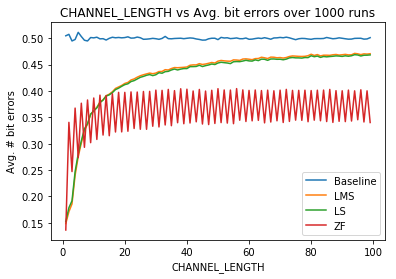

mu = 0.01
equalizer_L = 2
preamble_length = 100
algo = <function LMS at 0x108090a28>
test_length = 1000
snr = 0.8


In [8]:
# plot metric: channel length
channels = np.arange(1, 100, 1)
plot_metric("channel_length", channels , runs=1000)